# Применение оптимального транспорта для решения задачи сравнения распределений в А/В- и A/A-тестировании на синтетических данных

In [1]:
import pandas as pd
import numpy as np
import scipy
from numpy.linalg import norm
from numpy.random import default_rng
from random import choice

import scipy.stats as st
from scipy.optimize import linprog
from scipy.linalg import kron
from sklearn.metrics.pairwise import pairwise_distances
import pickle
import importlib
import os, sys

from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rc
from matplotlib.patches import Ellipse
from matplotlib.patches import Patch
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.ticker import StrMethodFormatter


from scipy.optimize import linear_sum_assignment
import re

In [2]:
def cost_matrix(X, Y):
    """
    Функция для построения ценовой матрицы C, где c_ij = ||X_i - Y_j||_2^2

    Параметры:
        X - array - выборка
        Y - array - выборка 
    Выход:
        cost - list[list] - ценовая матрица
    """
    x = np.shape(X)[0]
    y = np.shape(Y)[0]
    cost  = [[norm(X[i] - Y[j])**2 for i in range(x)] for j in range(y)]
    return(cost)

def gen_random_ball(dimension, num_points, rs = None, radius = 1):
    """
    Функция для генерации точек из равномерного распределения на шаре

    Параметры:
        dimension - int - размерность
        num_points - int - число объектов
        rs - int - для фиксации случайности
        radius - int - радиус шара
    Выход:
        ball - array - матрица размером num_points x dimension
    """

    # First generate random directions by normalizing the length of a
    # vector of random-normal values (these distribute evenly on ball)
    rng = default_rng(rs)
    random_directions = rng.standard_normal(size=(dimension, num_points))
    random_directions /= norm(random_directions, axis=0)
    # Second generate a random radius with probability proportional to
    # the surface area of a ball with a given radius.
    random_radii = rng.random(num_points) ** (1/dimension)
    # Return the list of random (direction & length) points.
    ball = radius * (random_directions * random_radii).T
    return ball

def split_data_randomly(d):
    """
    Функция случайно делит выборку из 2n точек на 2 группы по n точек

    Параметры:
        d - array -  матрица с данными
    Выход:
        s1 - array - объекты, попавшие в первую выборку
        s2 - array - объекты, попавшие во вторую выборку
    """
    ind = np.arange(d.shape[0])
    np.random.shuffle(ind)
    n = int(len(d)/2)
    ind1 = ind[:n]
    ind2 = ind[n:]

    s1 = d[ind1]
    s2 = d[ind2]
    return s1, s2

def compute_critical_level(ball, N, alpha):
    """
    Функция калибровки критического значения (алгоритм 3 из раздела 2.2.1 отчета)

    Параметры:
        ball - array - матрица с точками равномерного распределения на шаре
        N - int - число итераций
        alpha - float - уровень значимости
    Выход:
        cr_level - float - критическое значение
    """
    n = int(len(ball)/2)
    stat = []
    m0     = [1/n] * n
    m1     = [1/n] * n
    
    for i in range(0, N):
        s1, s2 = split_data_randomly(d = ball)
        plan = computeOT(s1, s2, 'distance') #ot distance
        stat.append(plan)

    q = (1 - alpha)*100
    cr_level = np.percentile(stat, q)
    return cr_level

def computeOT(s, t, mode):
    """
    Функция для подсчета оптимального транспортного плана 

    Параметры:
        s - array - выборка
        t - array - выборка
        mode - str - если равен "plan", то в функции находится оптимальный транспортный план, если значение равно "distance", то возвращается расстояние
    Выход:
        Если mode = "plan", то plan - array - искомый оптимальный план 
        Если mode = "distance", то plan - float - найденное расстояние
    """
    n = len(s)
    k = len(t)
    m0 = np.array([1/n] * n)
    m1 = np.array([1/k] * k)
    M = cost_matrix(s, t)
    M = np.array(M)
    
    # Составляем задачу линейного программирования c @ x -> min при условии A @ x == b, x >= 0
    # Вектор c соответствует векторизованной ценовой матрице
    # Условие A @ x == b получается из условий на маргинальные распределения
    c = M.reshape(-1)
    A = np.append(kron(np.ones((1, k)), np.eye(n)), kron(np.eye(k), np.ones((1, n))), axis=0)
    b = np.append(m0, m1)
    
    # Решаем задачу линейного программирования численно
    res = linprog(c, A_eq = A, b_eq = b, bounds = (0, None), method='highs-ipm')
    # Выдать предупреждение, если метод не сошелся
    if res.status != 0:
        print('Warning: the optimization method did not converge')
    # Транспортный план
    plan = res.x.reshape(n, k)
    # Расстояние Вассерштейна
    dst = res.fun
    #print(res.status, dst, np.linalg.norm(plan), np.linalg.norm(res.slack) / np.sqrt(n * k))
    
    if mode == 'plan':
        return plan
    elif mode == 'distance':
        return dst
    
    return


def compute_distance(s1, s2, t):
    """
    Функция для подсчета расстояние 2-Вассерштейна между эмпирическими распределениями (шаг 2 из алгоритма 3)

    Параметры:
        s1 - array - выборка
        s2 - array - выборка
        t - array - целевое распределение
    Выход:
        dst_fin - float - расстояние
    """  
    ##Step 2 in Algorithm 3: OT distance between ball partitions 
    ## induced by the transport of two data distributions
    L = len(s1)
    s = np.concatenate((s1, s2), axis = 0)
    plan = computeOT(s = t, t = s, mode = 'plan')
    # Матрица оптимального плана содержит только 2L ненулевых элементов,
    # однако из-за вычислительных погрешностей у найденного решения
    # будет много элементов, близких к нулю.
    # Отсекаем их вручную на уровне 10^{-6}
    plan = plan * np.abs(plan > 1e-6)
    ind = [np.nonzero(plan[i])[0][0] for i in range(2*L)] #indices of assigned distributions
    
    #split target t
    ind_t1 = []
    ind_t2 = []
    for i in range(0, len(s)):
        if i < L:
            ind_t1.append(ind[i])
        else:
            ind_t2.append(ind[i])
   
    t1 = t[ind_t1]
    t2 = t[ind_t2]
    dst_fin = computeOT(s = t1, t = t2, mode = 'distance')
    
    return dst_fin

# Вспомогательные функции для отрисовки графиков

def decompose(X, method = 'numpy.eigh'):
    """Собственное разложение матрицы X"""
    if method == "tf.eig":
        import tensorflow as tf
        A_tf = tf.convert_to_tensor(X)
        eigvals, eigvects = tf.linalg.eig(A_tf)
        eigvals, eigvects = eigvals.numpy(), eigvects.numpy()
    elif method == "tf.eigh":
        import tensorflow as tf
        A_tf = tf.convert_to_tensor(X)
        eigvals, eigvects = tf.linalg.eigh(A_tf)
        eigvals, eigvects = eigvals.numpy(), eigvects.numpy()
    elif method == "numpy.eig":
        eigvals, eigvects = np.linalg.eig(X)
    elif method == "numpy.eigh":
        eigvals, eigvects = np.linalg.eigh(X)
    else:
        raise NotImplementedError('Unknown method: ' + method)
    return eigvals, eigvects

def sqrtmInv(X, method='numpy.eigh'):
    """Вычисление обратной матрицы к корню матрицы X"""
    eigval, eigvects = decompose(X, method)
    Y = (eigvects / np.sqrt(np.maximum(eigval, 0))[np.newaxis,:]).dot(eigvects.T)
    return(Y)

def sqrtm(X, method='numpy.eigh'):
    """Вычисление корня симметричной матрицы"""
    eigval, eigvects = decompose(X, method)
    Y = (eigvects * np.sqrt(np.maximum(eigval, 0))[np.newaxis,:]).dot(eigvects.T)
    return(Y)


def BW(K1, K2, method='numpy.eigh'):
    """Вычисление 2-Вассерштейн расстояния между матрицами ковариаций нормального распределения"""
    Q = sqrtm(K1, method)
    d = np.sqrt(np.maximum(0, K1.trace() + K2.trace() - 2 * sqrtm(Q.dot(K2).dot(Q), method).trace()))
    return d

def OT_map(V, U):
    #map from V to U
    sqU = sqrtm(U,method='numpy.eigh')
    Cn  =  (sqU @ V) @ sqU
    Z = sqrtmInv(Cn, method='numpy.eigh')
#     pinvCn = pinvsq(Cn)
    T = (sqU @ Z) @ sqU
    return T

def OT_geod(V, T, t):
    E = np.array([[1,0],[0, 1]])
    Z = E * (1-t) + t*T
    V = Z @ V 
    W = V @ Z
    return W

## Примеры применения алгоритма к A/A- и A/B-тестированию на искусственных данных

#### Пример 1.

Две выборки случайных величин из гауссовского распределения $\mathcal N(0, 1)$. Тест не должен выявить значимого отличия.

In [3]:
np.random.seed(1)

# Задаем уровень значимости
alpha = 0.05

# Объем выборки
n = 20

# Генерируем 2 выборки из стандартного нормального распределения
X = np.random.randn(n)
Y = np.random.randn(n)

In [4]:
b = gen_random_ball(dimension=1, num_points=2*n, rs=1, radius = 1)
dst = compute_distance(s1 = X, s2 = Y, t=b)

In [5]:
# Проводим A/A-тестирование

# Шаг 1: сгенерировать 2n точек из равномерного распределения на сетке d-мерном шаре радиуса 1
# Размерность d совпадает с размерностью элементов выборки
b = gen_random_ball(dimension=1, num_points=2*n, rs=1, radius=1)

# Шаг 2: вычисляем критическое значение, соответствующее данному уровню значимости
cr_l = compute_critical_level(ball = b, N=1000, alpha=.05)

# Шаг 3: вычисляем тестовую статистику
dst = compute_distance(s1 = X, s2 = Y, t=b)

print('Значение тестовой статистики:', dst)
print('Критическое значение', cr_l)

# Сравниваем значение тестовой статистики с критическим, выносим решение об однородности выборок
if dst > cr_l :
    print('Гипотеза об однородности выборок отклоняется')
else:
    print('Данные не противоречат гипотезе об однородности выборок')

Значение тестовой статистики: 0.014945594688961812
Критическое значение 0.23493789953445102
Данные не противоречат гипотезе об однородности выборок


#### Пример 2.

Две выборки случайных величин из гауссовский распределений $\mathcal N(0, 1)$ и $\mathcal N(\mu, 1)$. Тест должен выявить значимое отличие.

In [6]:
np.random.seed(1)

# Задаем уровень значимости
alpha = 0.05

# Объем выборки
n = 50

# Генерируем выборку из стандартного нормального распределения N(0, 1)
X = np.random.randn(n)
# Генерируем выборку из нормального распределения N(mu, 1)
mu = 0.5
Y = mu + np.random.randn(n)

In [7]:
# Проводим A/B-тестирование

# Шаг 1: сгенерировать 2n точек из равномерного распределения на сетке d-мерном шаре радиуса 1
# Размерность d совпадает с размерностью элементов выборки
b = gen_random_ball(dimension=1, num_points=2*n, rs=1, radius=1)

# Шаг 2: вычисляем критическое значение, соответствующее данному уровню значимости
cr_l = compute_critical_level(ball=b, N=1000, alpha=.05)

# Шаг 3: вычисляем тестовую статистику
dst = compute_distance(s1 = X, s2 = Y, t=b)

print('Значение тестовой статистики:', dst)
print('Критическое значение', cr_l)

# Сравниваем значение тестовой статистики с критическим, выносим решение об однородности выборок
if dst > cr_l :
    print('Гипотеза об однородности выборок отклоняется')
else:
    print('Данные не противоречат гипотезе об однородности выборок')

Значение тестовой статистики: 0.2353145254636452
Критическое значение 0.06250368367555593
Гипотеза об однородности выборок отклоняется


#### Пример 3.

A/B-тестирование на данных банковских займов

In [8]:
# Загрузка данных
data = pd.read_csv('data/Loan_data_with_ID.csv', index_col=0)
print(data.shape)
print(data.head())

(601, 6)
   ID  Gender  Education  ApplicantIncome  LoanAmount  Loan_Status
0   0       0          1           5849.0       127.0            1
1   1       0          1           4583.0       128.0            0
2   2       0          1           3000.0        66.0            1
3   3       0          0           2583.0       120.0            1
4   4       0          1           6000.0       141.0            1


Изначального разбиения на контрольную и целевую группы нет, поэтому формируем их сами.

Проверим гипотезу о том, что наличие высшего образования не влияет на факт выдачи займа.

In [9]:
np.random.seed(1)

# Выбираем индивидов с высшим образованием
with_education = data[data['Education'] == 1]

# Выбираем индивидов без высшего образования
without_education = data[data['Education'] == 0]

# Объем выборки
n = 50

# Формируем выборки для A/B-тестирования
X = np.random.choice(with_education['Loan_Status'], size=n, replace=False).astype(float)
Y = np.random.choice(without_education['Loan_Status'], size=n, replace=False).astype(float)

print(X.mean(), X.std(), Y.mean(), Y.std())

0.7 0.45825756949558405 0.58 0.4935585071701226


In [10]:
# Проводим A/B-тестирование

# Шаг 1: сгенерировать 2n точек из равномерного распределения на сетке d-мерном шаре радиуса 1
# Размерность d совпадает с размерностью элементов выборки
b = gen_random_ball(dimension=1, num_points=2*n, rs=1, radius=1)

# Шаг 2: вычисляем критическое значение, соответствующее данному уровню значимости
cr_l = compute_critical_level(ball=b, N=1000, alpha=.05)

# Шаг 3: вычисляем тестовую статистику
dst = compute_distance(s1 = X, s2 = Y, t=b)

print('Значение тестовой статистики:', dst)
print('Критическое значение', cr_l)

# Сравниваем значение тестовой статистики с критическим, выносим решение об однородности выборок
if dst > cr_l :
    print('Гипотеза об однородности выборок отклоняется')
else:
    print('Данные не противоречат гипотезе об однородности выборок')

Значение тестовой статистики: 0.019017274469427463
Критическое значение 0.06354522263225877
Данные не противоречат гипотезе об однородности выборок


In [11]:
# Сравним результат со стандартным t-тестом

# Вызываем стандартный t-тест
ttest_res = scipy.stats.ttest_ind(X, Y, equal_var=False)
# Вычисляем p-value
p_value = ttest_res.pvalue
print('p-value:', p_value)

# Сравниваем p-value с уровнем значимости, выносим решение об однородности выборок
if p_value < 0.05 :
    print('Гипотеза об однородности выборок отклоняется')
else:
    print('Данные не противоречат гипотезе об однородности выборок')

p-value: 0.21530582861932795
Данные не противоречат гипотезе об однородности выборок


Итог: наличие высшего образования не имеет значимого влияния на шанс получения займа в банке.

## Проверка валидности критических значений

### Проверка валидности критических значений на одномерных данных: А/А-тест на данных из  гауссовского распределения с нулевым средним и дисперсией $\sigma^2$

In [12]:
np.random.seed(1)
# Генерируем стандартное отклонение
sigma = np.random.randn()**2
print('Стандартное отклонение:', sigma)

Стандартное отклонение: 2.638497860454269


In [13]:
# Для каждого n из списка sample_sizes = [10, 20, 30, 50, 70]
# генерируем Z = 200 пар выборок и вычисляем расстояние Вассерштейна между ними
sample_sizes = [10, 20, 30, 50, 70]
Z = 200

# Значения тестовой статистики
test_values  = []
# Критические значения
critical_levels = []

for n in tqdm(sample_sizes):
    
    # Шаг 1: сгенерировать 2n точек из равномерного распределения на сетке d-мерном шаре радиуса 1
    # Размерность d совпадает с размерностью элементов выборки
    b = gen_random_ball(dimension=1, num_points=2*n, rs=1, radius=1)

    # Шаг 2: вычисляем критическое значение, соответствующее данному уровню значимости
    cr_l = compute_critical_level(ball=b, N=1000, alpha=.05)
    critical_levels.append(cr_l)

    # Шаг 3: генерируем выборки Z = 100 раз и вычисляем значения тестовых статистик
    new_values = []
    for j in range(0, Z):
        # Генерация синтетических выборок
        s1 = sigma * np.random.randn(n)
        s2 = sigma * np.random.randn(n)
        
        # Подсчет тестовой статистики (Алгоритм 2, шаги 1, 3, 4, 5)
        plan = computeOT(s1, s2, 'plan')
        dst = compute_distance(s1 = s1, s2 =s2, t=b)
        new_values.append(dst)
    test_values.append(new_values)  

100%|█████████████████████████████████████████████| 5/5 [02:44<00:00, 32.96s/it]


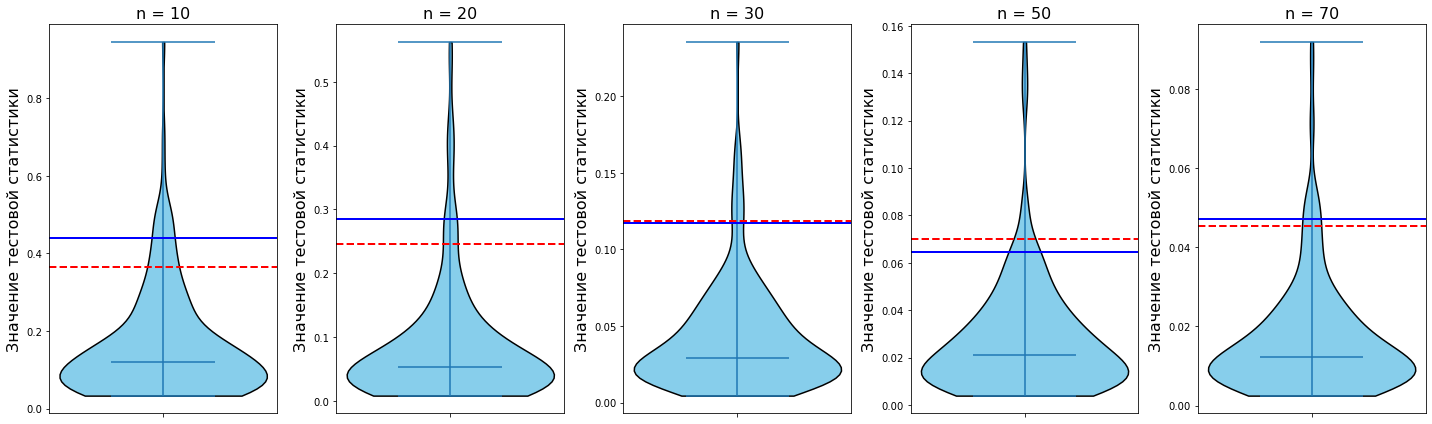

In [14]:
data = test_values

fig, axs = plt.subplots(1, len(sample_sizes), figsize=(20, 6))

for i, ax in enumerate(axs):
    parts = ax.violinplot(data[i], showmeans=False, showmedians=True)
    quantile_95 = np.percentile(data[i], 95)
    ax.axhline(y=quantile_95, color='blue', linestyle='-', linewidth=2)
    ax.axhline(y=critical_levels[i],  color='red', linestyle='--', linewidth=2)

    ax.set_title(f'n = {sample_sizes[i]}', fontsize=16)
    ax.set_xticks([1])
    ax.set_xticklabels([''])
    ax.set_ylabel(r'Значение тестовой статистики', fontsize=16)

    for pc in parts['bodies']:
        pc.set_facecolor('skyblue')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        pc.set_linewidth(1.5)


plt.tight_layout()
plt.show()

In [15]:
print('Разность между критичестким значением',\
      'и 95-м перцентилем тестовой статистики',\
      'при объемах выборок', sample_sizes, ':')

print([np.round(critical_levels[i] - np.percentile(data[i], 95), 4) for i in range(len(sample_sizes))])

print('Медианное значение тестовой статистики:')
print([np.round(np.percentile(data[i], 50), 4) for i in range(len(sample_sizes))])

Разность между критичестким значением и 95-м перцентилем тестовой статистики при объемах выборок [10, 20, 30, 50, 70] :
[-0.0731, -0.0391, 0.0015, 0.0057, -0.0018]
Медианное значение тестовой статистики:
[0.1205, 0.053, 0.0292, 0.0212, 0.0123]


In [16]:
type_i_err = [np.sum(data[i] > critical_levels[i]) / Z for i in range(len(sample_sizes))]

print('Ошибки I рода:')
print(np.round(type_i_err, 4))

Ошибки I рода:
[0.095 0.075 0.05  0.035 0.06 ]


### Проверка валидности критических значений на двумерных данных: А/А-тест на данных из  гауссовского распределения с нулевым средним и ковариационной матрицей $\Sigma$

In [64]:
np.random.seed(1)
# Генерируем ковариационную матрицу
A = np.random.randn(2, 2)
Sigma = A @ A.T
print('Ковариационная матрица:\n', Sigma)

Ковариационная матрица:
 [[ 3.01274377 -0.2015379 ]
 [-0.2015379   1.43022706]]


In [65]:
# Для каждого n из списка sample_sizes = [10, 20, 30, 50, 70]
# генерируем Z = 200 пар выборок и вычисляем расстояние Вассерштейна между ними
sample_sizes = [10, 20, 30, 50, 70]
Z = 200

# Значения тестовой статистики
test_values  = []
# Критические значения
critical_levels = []

for n in tqdm(sample_sizes):
    
    # Шаг 1: сгенерировать 2n точек из равномерного распределения на сетке d-мерном шаре радиуса 1
    # Размерность d совпадает с размерностью элементов выборки
    b = gen_random_ball(dimension=2, num_points=2*n, rs=1, radius=1)

    # Шаг 2: вычисляем критическое значение, соответствующее данному уровню значимости
    cr_l = compute_critical_level(ball=b, N=1000, alpha=.05)
    critical_levels.append(cr_l)

    # Шаг 3: генерируем выборки Z = 100 раз и вычисляем значения тестовых статистик
    new_values = []
    for j in range(0, Z):
        # Генерация синтетических выборок
        s1 = np.random.multivariate_normal(np.zeros(2), Sigma, n)
        s2 = np.random.multivariate_normal(np.zeros(2), Sigma, n)
        
        # Подсчет тестовой статистики (Алгоритм 2, шаги 1, 3, 4, 5)
        plan = computeOT(s1, s2, 'plan')
        dst = compute_distance(s1 = s1, s2 =s2, t=b)
        new_values.append(dst)
    test_values.append(new_values)  

100%|█████████████████████████████████████████████| 5/5 [02:34<00:00, 30.90s/it]


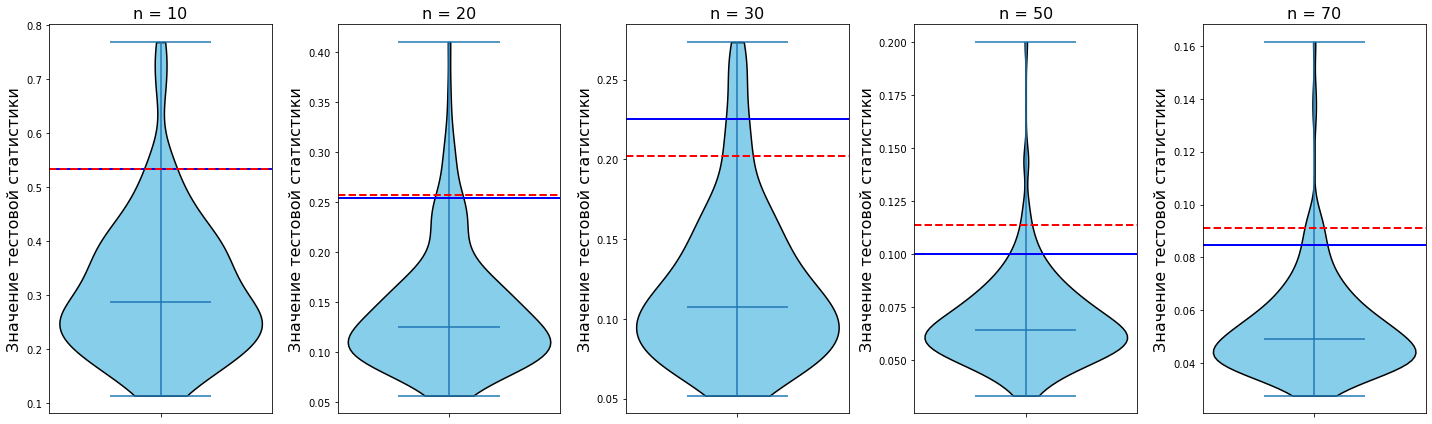

In [66]:
data = test_values

fig, axs = plt.subplots(1, len(sample_sizes), figsize=(20, 6))

for i, ax in enumerate(axs):
    parts = ax.violinplot(data[i], showmeans=False, showmedians=True)
    quantile_95 = np.percentile(data[i], 95)
    ax.axhline(y=quantile_95, color='blue', linestyle='-', linewidth=2)
    ax.axhline(y=critical_levels[i],  color='red', linestyle='--', linewidth=2)

    ax.set_title(f'n = {sample_sizes[i]}', fontsize=16)
    ax.set_xticks([1])
    ax.set_xticklabels([''])
    ax.set_ylabel(r'Значение тестовой статистики', fontsize=16)

    for pc in parts['bodies']:
        pc.set_facecolor('skyblue')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        pc.set_linewidth(1.5)


plt.tight_layout()
plt.show()

In [67]:
print('Разность между критичестким значением',\
      'и 95-м перцентилем тестовой статистики',\
      'при объемах выборок', sample_sizes, ':')

print([np.round(critical_levels[i] - np.percentile(data[i], 95), 4) for i in range(len(sample_sizes))])

print('Медианное значение тестовой статистики:')
print([np.round(np.percentile(data[i], 50), 4) for i in range(len(sample_sizes))])

Разность между критичестким значением и 95-м перцентилем тестовой статистики при объемах выборок [10, 20, 30, 50, 70] :
[-0.0014, 0.0037, -0.0232, 0.0135, 0.0062]
Медианное значение тестовой статистики:
[0.2878, 0.1252, 0.1076, 0.0641, 0.0489]


In [68]:
type_i_err = [np.sum(data[i] > critical_levels[i]) / Z for i in range(len(sample_sizes))]

print('Ошибки I рода:')
print(np.round(type_i_err, 4))

Ошибки I рода:
[0.06  0.045 0.08  0.025 0.035]


### Проверка валидности критических значений на многомерных данных: А/А-тест на данных размерности 4 из  гауссовского распределения с нулевым средним и ковариационной матрицей $\Sigma$

In [69]:
np.random.seed(1)
# Генерируем ковариационную матрицу
A = np.random.randn(4, 4)
Sigma = A @ A.T
print('Ковариационная матрица:\n', Sigma)

Ковариационная матрица:
 [[4.44297083 2.70889276 2.10900583 0.29255465]
 [2.70889276 9.66981478 4.96933089 3.42035273]
 [2.10900583 4.96933089 6.54591089 3.91653216]
 [0.29255465 3.42035273 3.91653216 2.74664455]]


In [70]:
# Для каждого n из списка sample_sizes = [10, 20, 30, 50, 70]
# генерируем Z = 100 пар выборок и вычисляем расстояние Вассерштейна между ними
sample_sizes = [10, 20, 30, 50, 70]
Z = 200

# Значения тестовой статистики
test_values  = []
# Критические значения
critical_levels = []

for n in tqdm(sample_sizes):
    
    # Шаг 1: сгенерировать 2n точек из равномерного распределения на сетке d-мерном шаре радиуса 1
    # Размерность d совпадает с размерностью элементов выборки
    b = gen_random_ball(dimension=4, num_points=2*n, rs=1, radius=1)

    # Шаг 2: вычисляем критическое значение, соответствующее данному уровню значимости
    cr_l = compute_critical_level(ball=b, N=1000, alpha=.05)
    critical_levels.append(cr_l)

    # Шаг 3: генерируем выборки Z = 100 раз и вычисляем значения тестовых статистик
    new_values = []
    for j in range(0, Z):
        # Генерация синтетических выборок
        s1 = np.random.multivariate_normal(np.zeros(4), Sigma, n)
        s2 = np.random.multivariate_normal(np.zeros(4), Sigma, n)
        
        # Подсчет тестовой статистики (Алгоритм 2, шаги 1, 3, 4, 5)
        plan = computeOT(s1, s2, 'plan')
        dst = compute_distance(s1 = s1, s2 =s2, t=b)
        new_values.append(dst)
    test_values.append(new_values)  

100%|█████████████████████████████████████████████| 5/5 [02:30<00:00, 30.18s/it]


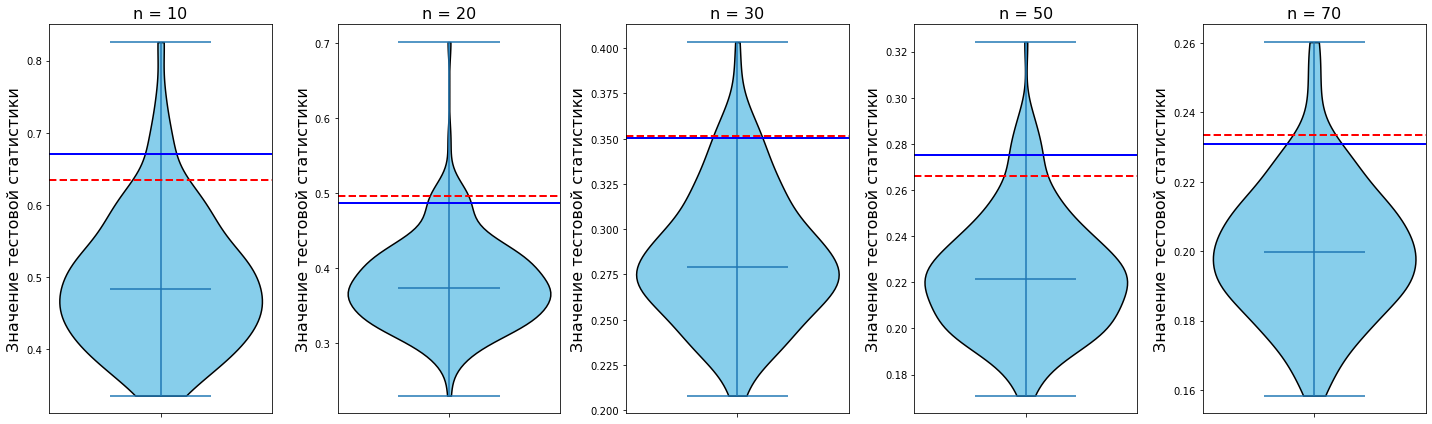

In [71]:
data = test_values

fig, axs = plt.subplots(1, len(sample_sizes), figsize=(20, 6))

for i, ax in enumerate(axs):
    parts = ax.violinplot(data[i], showmeans=False, showmedians=True)
    quantile_95 = np.percentile(data[i], 95)
    ax.axhline(y=quantile_95, color='blue', linestyle='-', linewidth=2)
    ax.axhline(y=critical_levels[i],  color='red', linestyle='--', linewidth=2)

    ax.set_title(f'n = {sample_sizes[i]}', fontsize=16)
    ax.set_xticks([1])
    ax.set_xticklabels([''])
    ax.set_ylabel(r'Значение тестовой статистики', fontsize=16)

    for pc in parts['bodies']:
        pc.set_facecolor('skyblue')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        pc.set_linewidth(1.5)


plt.tight_layout()
plt.show()

In [72]:
print('Разность между критичестким значением',\
      'и 95-м перцентилем тестовой статистики',\
      'при объемах выборок', sample_sizes, ':')

print([np.round(critical_levels[i] - np.percentile(data[i], 95), 4) for i in range(len(sample_sizes))])

print('Медианное значение тестовой статистики:')
print([np.round(np.percentile(data[i], 50), 4) for i in range(len(sample_sizes))])

Разность между критичестким значением и 95-м перцентилем тестовой статистики при объемах выборок [10, 20, 30, 50, 70] :
[-0.0352, 0.0085, 0.001, -0.0091, 0.0027]
Медианное значение тестовой статистики:
[0.4829, 0.3738, 0.279, 0.2214, 0.1997]


In [73]:
type_i_err = [np.sum(data[i] > critical_levels[i]) / Z for i in range(len(sample_sizes))]

print('Ошибки I рода:')
print(np.round(type_i_err, 4))

Ошибки I рода:
[0.065 0.04  0.05  0.07  0.04 ]


# Эксперименты на синтетических данных из раздела 2.2.2 отчета

В данных экспериментах рассматриваются две выборки одинакового размера, пришедшие из центрированных двумерных Гауссовских распределений с матрицами ковариаций
$$
C_0 = \begin{pmatrix}
5 & 2 \\
2 & 2 
\end{pmatrix},
\quad
C_1 = \begin{pmatrix}
12 & 4 \\
4 & 15 
\end{pmatrix}.
$$

In [12]:
m = [0, 0]

# Выборка X
C0=np.array([[5, 2], [2, 2]])

# Выборка Y
C1=np.array([[12.0, 4], [4, 15.0]])
m = [0, 0]
 

## Исследование поведения метода на выборках разного размера

В данном эксперименте рассматривались размеры выборок, равные 10, 20, 30, 50 и 70

In [13]:
# Значения параметров размера выборки
grd = [10, 20, 30, 50, 70]

test_values  = []

# Число итераций алгоритма
Z = 100

critical_levels = []
for g in tqdm(grd):

    # Алгоритм 2, шаг 2
    b = gen_random_ball(dimension=2, num_points=2*g, rs=None, radius = 1)

    # Алгоритм 3
    cr_l = compute_critical_level(ball = b, N=1500, alpha=.05)
    critical_levels.append(cr_l)
    
    #resampling for a given sample size: store test values 
    dummy = []
    for j in range(0, Z):
        # Генерация синтетических выборок
        s1 = np.random.multivariate_normal(m, C0, g)
        s2 = np.random.multivariate_normal(m, C1, g)
        
        # Подсчет тестовой статистики (Алгоритм 2, шаги 1, 3, 4, 5)
        plan = computeOT(s1, s2, 'plan')
        dst = compute_distance(s1 = s1, s2 =s2, t=b)
        dummy.append(dst)
    test_values.append(dummy)  

100%|█████████████████████████████████████████████| 5/5 [02:19<00:00, 27.93s/it]


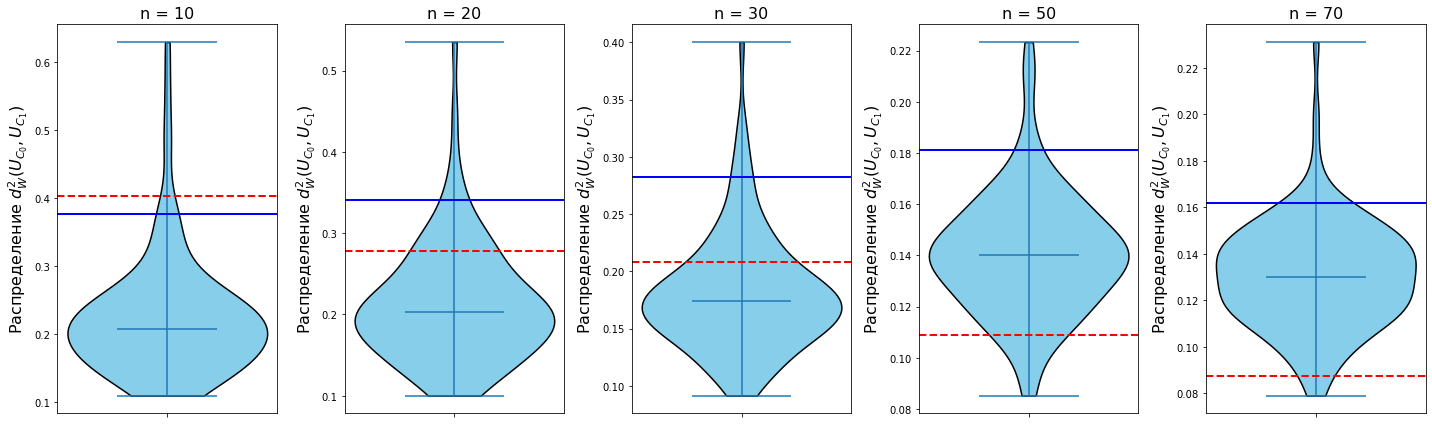

In [14]:
data = test_values

fig, axs = plt.subplots(1, len(grd), figsize=(20, 6))

for i, ax in enumerate(axs):
    parts = ax.violinplot(data[i], showmeans=False, showmedians=True)
    quantile_95 = np.percentile(data[i], 95)
    ax.axhline(y=quantile_95, color='blue', linestyle='-', linewidth=2)
    ax.axhline(y=critical_levels[i],  color='red', linestyle='--', linewidth=2)

    ax.set_title(f'n = {grd[i]}', fontsize=16)
    ax.set_xticks([1])
    ax.set_xticklabels([''])
    ax.set_ylabel(r'Распределение $d_{W}^2(U_{C_0}, U_{C_1})$', fontsize=16)

    for pc in parts['bodies']:
        pc.set_facecolor('skyblue')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        pc.set_linewidth(1.5)


plt.tight_layout()
plt.show()


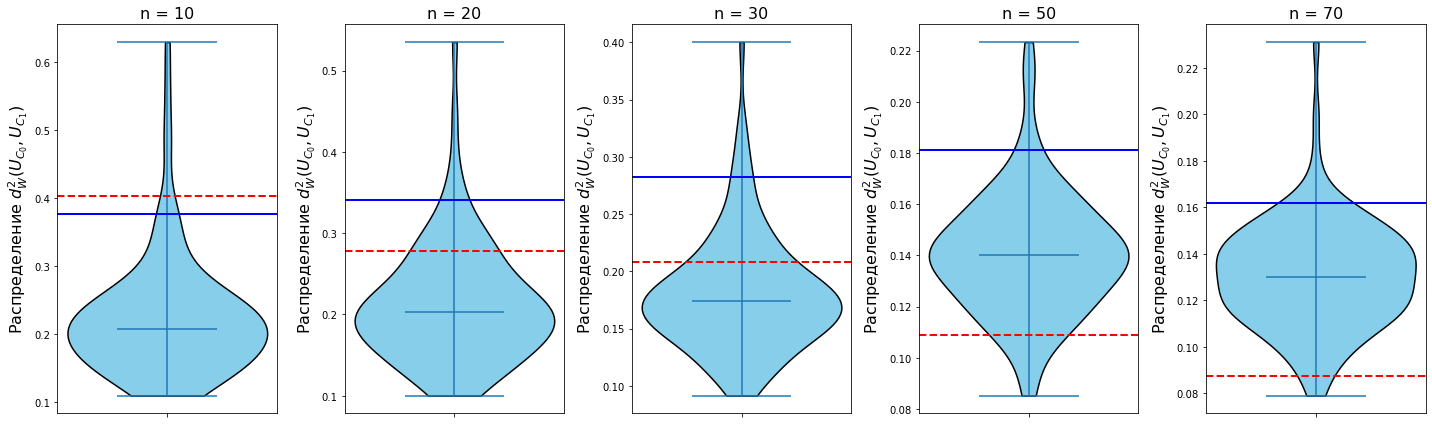

In [15]:
data = test_values

fig, axs = plt.subplots(1, len(grd), figsize=(20, 6))

for i, ax in enumerate(axs):
    parts = ax.violinplot(data[i], showmeans=False, showmedians=True)
    quantile_95 = np.percentile(data[i], 95)
    ax.axhline(y=quantile_95, color='blue', linestyle='-', linewidth=2)
    ax.axhline(y=critical_levels[i],  color='red', linestyle='--', linewidth=2)


    ax.set_title(f'n = {grd[i]}', fontsize=16)
    ax.set_xticks([1])
    ax.set_xticklabels([''])
    ax.set_ylabel(r'Распределение $d_{W}^2(U_{C_0}, U_{C_1})$', fontsize=16)

    
    for pc in parts['bodies']:
        pc.set_facecolor('skyblue')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        pc.set_linewidth(1.5)


plt.tight_layout()
plt.savefig('images/different_n.png')
plt.show()


## Анализ чувствительности метода к разладке

Для проведения данного эксперимента поведение метода было исследовано на различных ковариационных матрицах $C_t$, лежащих между $C_1$ и $C_2$ на геодезической в пространстве $2$-Вассерштейна,
$$
C_t = (E(1-t) + Tt)C_0(E(1-t) + Tt), 
\quad
t\in [0, 1],
$$
где 
$
E = \begin{pmatrix}
1 & 0 \\
0 & 1 
\end{pmatrix},
\quad
T = C^{1/2}_1\left(C^{1/2}_1 C_0 C^{1/2}_1 \right)^{-1/2}C^{1/2}_1.
$

In [16]:
#Changepoint is simulated as a movement over geodesic in 2-Wasserstein space 
#connecting the data generating distributions N(0, C0) and N(0, C1)


#step at geodesic
grd = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]

#find optimal map between C0 and C1
mapT = OT_map(C0, C1)

#store change point values
stat_BW = []

#store test statistic values
stat_U  = []

#num of iterations to estimate the distribution of the test
Z = 100

#num of points in each sample
num_points = 80

# #generate points from uniform distributopm on a ball
b = gen_random_ball(dimension=2, num_points=2*num_points, rs=None, radius = 1) #(see Algorithm 2, steps 2) 

#compute critical level
cr_l = compute_critical_level(ball = b, N=1500, alpha=.05) #(see Algorithm 3) 

#move along geodesic
for t in grd:
    if t == 0:
        gC = C0
    elif t == 1:
        gC = C1
    else: 
         gC = OT_geod(C0, mapT, t)
    
    stat_BW.append(BW(C0, gC))#distance between data generating distributions
    dummy = []
    for j in tqdm(range(0, Z)):
        s1 = np.random.multivariate_normal(m, C0, num_points)
        s2 = np.random.multivariate_normal(m, gC, num_points)
        dst = compute_distance(s1 = s1, s2 =s2, t=b)
        dummy.append(dst)
    stat_U.append(dummy)
    

100%|█████████████████████████████████████████| 100/100 [00:35<00:00,  2.85it/s]


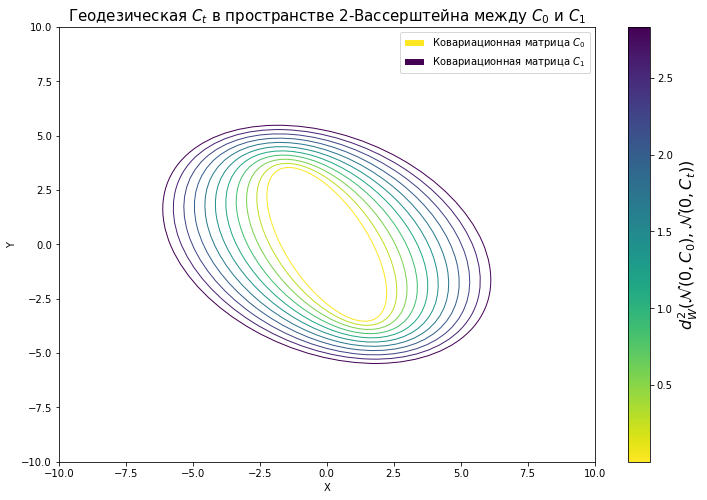

In [22]:
data_to_plot = np.array(stat_BW)


nrm = Normalize(vmin=data_to_plot.min(), vmax=data_to_plot.max())
colors = plt.cm.viridis_r(nrm(data_to_plot))


fig, ax = plt.subplots(figsize=(12, 8))

k = -1
for g in grd:
    k+=1
    gC = OT_geod(C0, mapT, g)
    eigenvalues, eigenvectors = np.linalg.eigh(gC)
    theta = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    ellipse = Ellipse((0, 0), 2 * np.sqrt(2.5 * eigenvalues[1]), 2 * np.sqrt(2.5 * eigenvalues[0]),
                      angle=theta, color=colors[k], fill = False)
    ax.add_patch(ellipse)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(r'Геодезическая $C_t$ в пространстве 2-Вассерштейна между $C_0$ и $C_1$', fontsize=15)


sm = ScalarMappable(norm=nrm, cmap=plt.cm.viridis_r)
sm.set_array([]) 
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'$d_W^2(\mathcal{N}(0, C_0), \mathcal{N}(0, C_t))$', fontsize=16)

legend_elements = [
    Patch(facecolor=colors[0], edgecolor='white', label=r'Ковариационная матрица $C_0$'),
    Patch(facecolor=colors[-1], edgecolor='white', label=r'Ковариационная матрица $C_1$')
]
ax.legend(handles=legend_elements)
plt.savefig('images/geodesic.png')
plt.show()


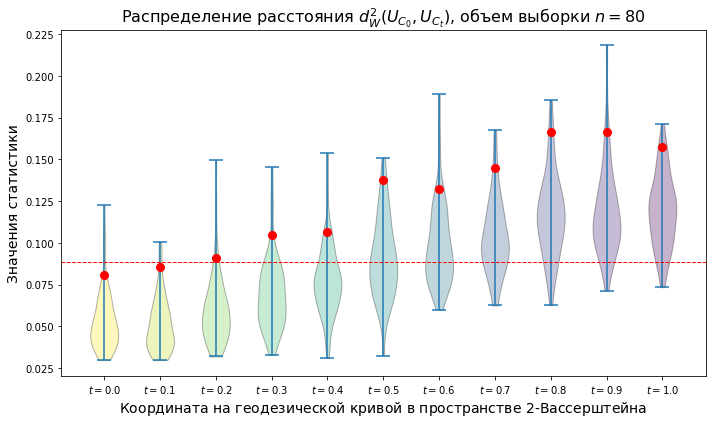

In [21]:

fig_violin, ax_violin = plt.subplots(figsize=(10, 6))

num_ticks = len(grd)

data_to_plot = stat_U
quantiles = [np.percentile(dataset, 95) for dataset in data_to_plot]

violin_parts = ax_violin.violinplot(data_to_plot, showmeans=False, showmedians=False)
for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    ax_violin.plot([i + 1], [quantiles[i]], marker='o', markersize=8, color='red', zorder=3)



ax_violin.set_xticks(np.arange(1, num_ticks + 1))
ax_violin.set_xticklabels([fr'$t = {(i-1)/10}$' for i in range(1, num_ticks + 1)])
ax_violin.set_xlabel(r'Координата на геодезической кривой в пространстве $2$-Вассерштейна', fontsize=14)
ax_violin.set_ylabel('Значения статистики', fontsize=14)
ax_violin.set_title(r'Распределение расстояния $d_{W}^2(U_{C_0}, U_{C_t})$, объем выборки $n=80$', fontsize=16)

ax_violin.axhline(y=cr_l, color='red', linestyle='--', linewidth=1, label='Критическое значение')



plt.tight_layout()
plt.savefig('images/cp_size.png')
plt.show()

